In [1]:
import pandas as pd
import numpy as np

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

# ML and statistics
from scipy.stats import chi2_contingency
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score

RANDOM_STATE = 42

In [ ]:
# check to make sure data was imported correctly
recall_df_full = pd.read_csv("data/recalls_data.csv") # data/recalls_data.csv
print(recall_df_full.shape)
display(recall_df_full.head())

FileNotFoundError: [Errno 2] No such file or directory: 'data/recalls_data.csv'

In [ ]:
# in our assessment, we will only use vehicle data
unique_recall_type = recall_df_full['Recall Type'].value_counts()

print(unique_recall_type)

num_unique_from_counts = len(unique_recall_type)
print(f"Number of Unique Categories (from value_counts): {num_unique_from_counts}")

Recall Type
Vehicle       25564
Equipment      2782
Tire            775
Child Seat      246
Name: count, dtype: int64
Number of Unique Categories (from value_counts): 4


In [ ]:
# remove rows that are not 'vehicle' in Recall Type
recall_df = recall_df_full[recall_df_full['Recall Type'] == 'Vehicle']

print(recall_df.shape)

(25564, 15)


## Evaluate Missing Data

In [ ]:
#print number of missing entries in each column
print(f'Number of Values in Dataset: {recall_df.shape[0]}')
print("Missing Entries")
print(recall_df.isna().sum())

# interpretation
# text-based columns have some missing data that needs to be managed
  # Component - 25% missing
  # Recall Description - 8.2%
  # Consequence Summary - 16.6%
  # Corrective Action - 8.1%
# completion rate has high missingness (63.6%), making it unusable for our analysis

Number of Values in Dataset: 25564
Missing Entries
Report Received Date                            0
NHTSA ID                                        0
Recall Link                                     0
Manufacturer                                    0
Subject                                         0
Component                                    6188
Mfr Campaign Number                            97
Recall Type                                     0
Potentially Affected                            0
Recall Description                           2178
Consequence Summary                          4121
Corrective Action                            2165
Park Outside Advisory                           0
Do Not Drive Advisory                           0
Completion Rate % (Blank - Not Reported)    15897
dtype: int64


In [ ]:
#test whether missing values in consequence summary are independent of manufacturer using chi^2 test of independence
recall_df["missingConsequence"] = recall_df["Consequence Summary"].isna().astype(int)
missingTable = pd.crosstab(recall_df["Manufacturer"], recall_df["missingConsequence"])
chi2, p, dof, expected = chi2_contingency(missingTable)

#output results - missing values in consequence summary are not independent of manufacturer
print(f"Chi-square statistic = {chi2:.3f}")
print(f"Degrees of freedom = {dof}")
print(f"p-value = {p:.3e}")

# intrepretation of chi square result
# missing Consequences Summary values depend on manufacturer
# missingness is not random

Chi-square statistic = 9863.156
Degrees of freedom = 1839
p-value = 0.000e+00


/tmp/ipython-input-2576525128.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recall_df["missingConsequence"] = recall_df["Consequence Summary"].isna().astype(int)


##Data Cleaning
Extract dates, manage missing data

In [ ]:
#drop any rows missing manufacturer and/or recall date from df
recall_df = recall_df.dropna(subset=['Manufacturer', 'Report Received Date'])

In [ ]:
# split extraction date into month, day, and year from recall_date col
# allow for assessment of yearly and monthly trends

recall_df['Report Received Date'] = pd.to_datetime(recall_df['Report Received Date'], errors='coerce')
recall_df = recall_df.dropna(subset=['Report Received Date']) # drop rows where date conversion failed

# extract date components
recall_df['Year'] = recall_df['Report Received Date'].dt.year
recall_df['Month'] = recall_df['Report Received Date'].dt.month
recall_df['Day'] = recall_df['Report Received Date'].dt.day

# add cols for month name and day of week to aid in exploratory analysis
recall_df['Month Name'] = recall_df['Report Received Date'].dt.month_name()
recall_df['Day of Week'] = recall_df['Report Received Date'].dt.day_name()

In [ ]:
# handle remaining missing vals and check again for missingness

# drop Completion Rate col - this col will be ignored in analysis due to high missingness
recall_df.drop(columns=['Completion Rate % (Blank - Not Reported)'], inplace=True)

#fill in any blank consequence summaries and component
recall_df['Consequence Summary'] = recall_df['Consequence Summary'].fillna("No description")
recall_df['Component'] = recall_df['Component'].fillna("Unknown")

recall_df.isna().sum()

,0
Report Received Date,0
NHTSA ID,0
Recall Link,0
Manufacturer,0
Subject,0
Component,0
Mfr Campaign Number,97
Recall Type,0
Potentially Affected,0
Recall Description,2178


In [ ]:
# make df with only feature cols
#print(recall_df.columns.tolist())

feature_cols= ['Year', 'Month Name', 'Day of Week',
               'Manufacturer', 'Component', 'Recall Type',
               'Do Not Drive Advisory','Potentially Affected', 'Consequence Summary'
               ]
recall_df = recall_df[feature_cols]
display(recall_df)

,Year,Month Name,Day of Week,Manufacturer,Component,Recall Type,Do Not Drive Advisory,Potentially Affected,Consequence Summary
0,2025,September,Tuesday,Thor Motor Coach,EQUIPMENT,Vehicle,No,23,A detached tank can create a road hazard for o...
2,2025,September,Thursday,"Kia America, Inc.",ELECTRICAL SYSTEM,Vehicle,No,39536,A fire increases the risk of injury.
4,2025,September,Thursday,"Jaguar Land Rover North America, LLC",BACK OVER PREVENTION,Vehicle,No,3818,A rearview camera image that does not display ...
5,2025,September,Thursday,"BMW of North America, LLC",ELECTRICAL SYSTEM,Vehicle,No,145102,An overheated starter motor can ignite nearby ...
6,2025,September,Thursday,"BMW of North America, LLC",ELECTRICAL SYSTEM,Vehicle,No,4,An engine stall increases the risk of a crash ...
...,...,...,...,...,...,...,...,...,...
29362,1966,September,Thursday,Honda (American Honda Motor Co.),POWER TRAIN,Vehicle,No,18572,No description
29363,1966,September,Monday,"RENAULT, INCORPORATED","SERVICE BRAKES, HYDRAULIC",Vehicle,No,125,IF SUCH LEAKAGE OCCURS AND IF ENOUGH BRAKE FLU...
29364,1966,January,Wednesday,"General Motors, LLC",STEERING,Vehicle,No,138878,No description
29365,1966,January,Wednesday,"General Motors, LLC",STEERING,Vehicle,No,70644,No description


##Exploratory Data Analysis and Visualization
Assess trends, patterns, distribution

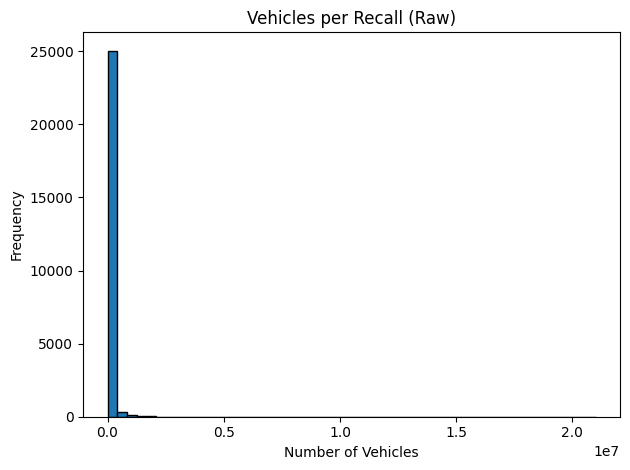

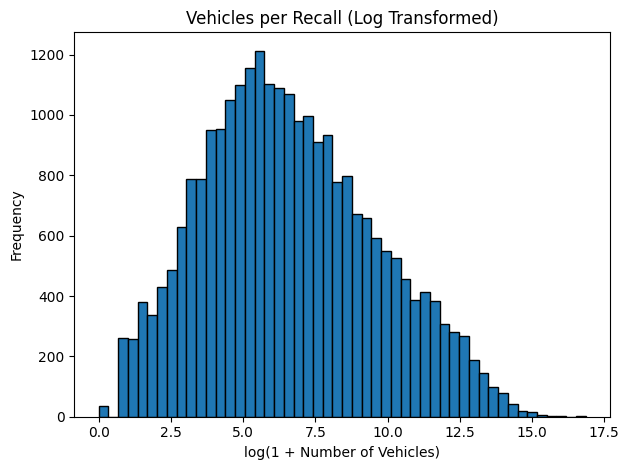

In [ ]:
#Plot distribution of number of vehicles affected per recall
recall_df["Potentially Affected"].plot(kind="hist", bins = 50, edgecolor='black')
plt.title("Vehicles per Recall (Raw)")
plt.xlabel("Number of Vehicles")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

#Number vehicles per recall is right skewed, so log transform to normalize
np.log1p(recall_df["Potentially Affected"]).plot(kind="hist", bins = 50, edgecolor='black')
plt.title("Vehicles per Recall (Log Transformed)")
plt.xlabel("log(1 + Number of Vehicles)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

#Save log transformation in dataset
recall_df["Potentially_Affected_LogTransform"] = np.log1p(recall_df["Potentially Affected"])



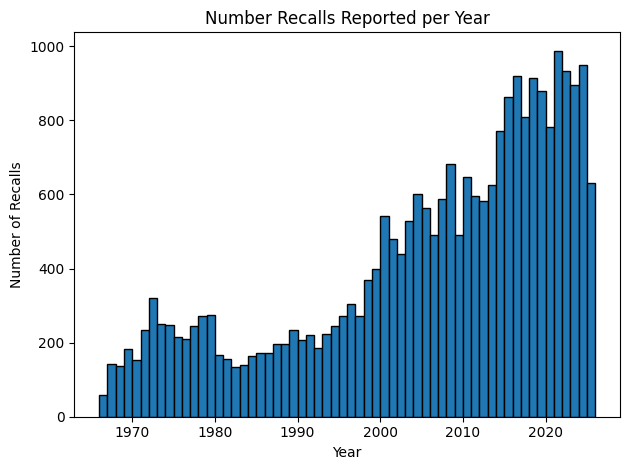

Summary of Recalls per Year:
 Average Recalls    426.066667
Median Recalls     289.000000
Min Recalls         58.000000
Max Recalls        988.000000
dtype: float64


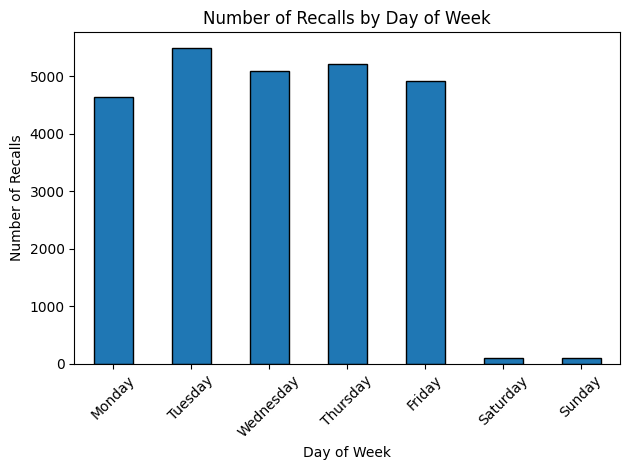

Summary of Recalls per Week Day:
 Average Recalls    3652.0
Median Recalls     4916.0
Min Recalls         105.0
Max Recalls        5488.0
dtype: float64


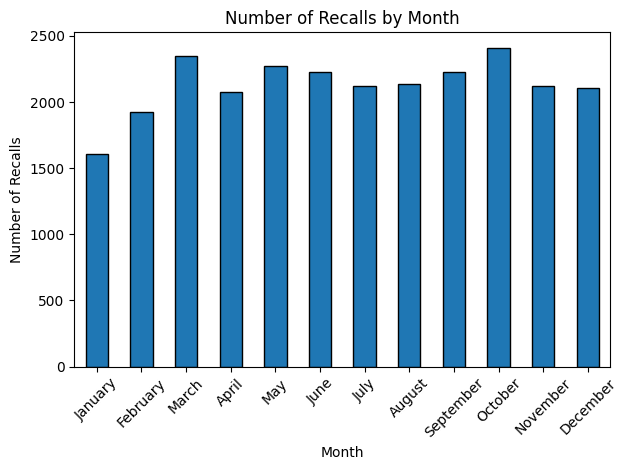

Summary of Recalls per Month:
 Average Recalls    2130.333333
Median Recalls     2127.000000
Min Recalls        1607.000000
Max Recalls        2407.000000
dtype: float64


In [ ]:
# date / time trends for number of recalls

#Plot number of recalls per year for entire dataset
# recalls increasing over the years - why?
# note that 2025 is low bc we do not have complete data
plt.hist(recall_df['Year'], bins=range(1966, 2027), edgecolor='black')
plt.title("Number Recalls Reported per Year")
plt.xlabel("Year")
plt.ylabel("Number of Recalls")
plt.tight_layout()
plt.show()

#Summary table: recalls per year
recalls_per_year_counts = recall_df.groupby('Year').size()
year_summary = recalls_per_year_counts.agg(['mean', 'median', 'min', 'max']).rename({'mean': 'Average Recalls', 'median': 'Median Recalls', 'min': 'Min Recalls', 'max': 'Max Recalls'})
print("Summary of Recalls per Year:\n", year_summary)

# histogram for day of week recalls
# no significant patterns found
# it is expected that recalls are announced M-F because of work week
# are recalls made on Sat / Sun very severe?
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

recall_df['Day of Week'].value_counts().reindex(day_order).plot(
    kind='bar', edgecolor='black')
plt.title("Number of Recalls by Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Number of Recalls")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#Summary table: recalls per day
recalls_per_day_counts = recall_df.groupby('Day of Week').size().reindex(day_order)
day_summary = recalls_per_day_counts.agg(['mean', 'median', 'min', 'max']).rename({'mean': 'Average Recalls', 'median': 'Median Recalls', 'min': 'Min Recalls', 'max': 'Max Recalls'})
print("Summary of Recalls per Week Day:\n", day_summary)


# histogram for monthly recalls
# jan and feb have lowest num of recalls announced
# march and october have the highest
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']

recall_df['Month Name'].value_counts().reindex(month_order).plot(
    kind='bar', edgecolor='black')
plt.title("Number of Recalls by Month")
plt.xlabel("Month")
plt.ylabel("Number of Recalls")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#Summary table: recalls per Month
recalls_per_month_counts = recall_df.groupby('Month Name').size().reindex(month_order)
month_summary = recalls_per_month_counts.agg(['mean', 'median', 'min', 'max']).rename({'mean': 'Average Recalls', 'median': 'Median Recalls', 'min': 'Min Recalls', 'max': 'Max Recalls'})
print("Summary of Recalls per Month:\n", month_summary)

                                Manufacturer  Number of Recalls
0                        General Motors, LLC               1675
1                         Ford Motor Company               1611
2                     Chrysler (FCA US, LLC)               1407
3                         Forest River, Inc.                604
4          Volkswagen Group of America, Inc.                577
5                  BMW of North America, LLC                559
6          Daimler Trucks North America, LLC                523
7                     Mercedes-Benz USA, LLC                486
8           Honda (American Honda Motor Co.)                444
9                 Nissan North America, Inc.                427
10                         Mack Trucks, Inc.                416
11                       PACCAR Incorporated                410
12                    Blue Bird Body Company                397
13                 International Motors, LLC                387
14                          FREIGHTLINER

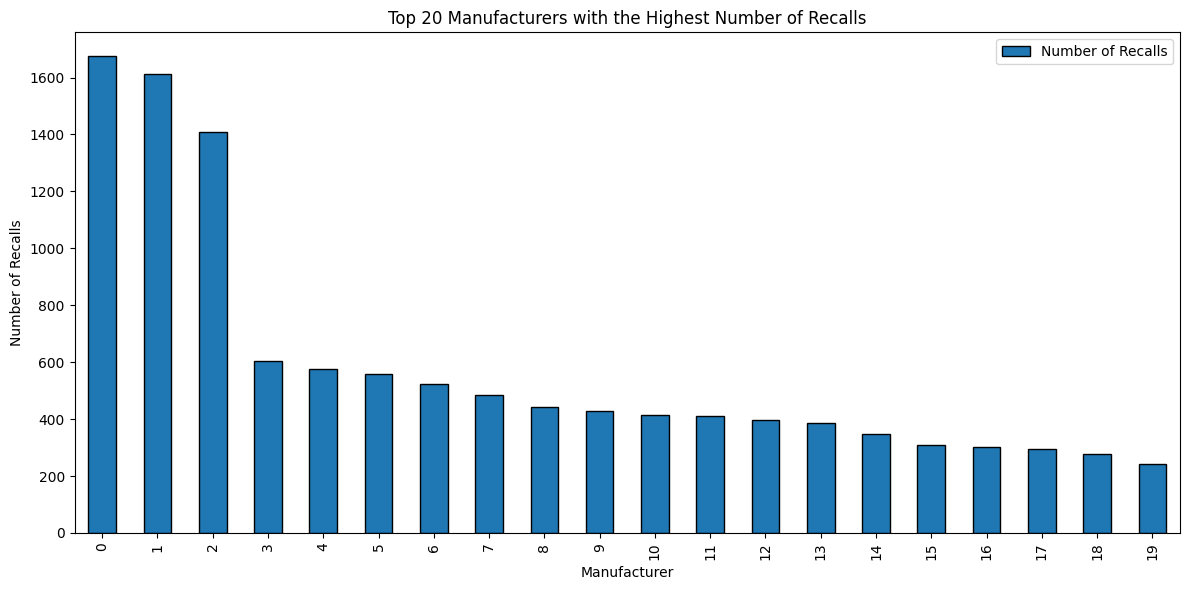

In [ ]:
#Number of Recalls per Manufacturer
recalls_per_manufacturer = recall_df.groupby('Manufacturer').size().sort_values(ascending=False).reset_index(name='Number of Recalls')
print(recalls_per_manufacturer.head(20))

#plot recalls per manufacturer
top_n = 20
recalls_per_manufacturer.head(top_n).plot(kind='bar', edgecolor='black', figsize=(12,6))
plt.title('Top 20 Manufacturers with the Highest Number of Recalls')
plt.xlabel('Manufacturer')
plt.ylabel('Number of Recalls')
plt.tight_layout()
plt.show()

                                                   mean    median    min  \
Manufacturer                                                               
Harbor Freight Tools                      234778.000000  234778.0  95237   
Toyota Motor Engineering & Manufacturing  226760.838710   37684.0      2   
Honda (American Honda Motor Co.)          178050.245495   11556.5      0   
Tesla, Inc.                               156266.904762    7444.5      1   
Ford Motor Company                        136556.285537    9400.0      1   
General Motors, LLC                       122153.197612    6083.0      0   
Chrysler (FCA US, LLC)                    102248.867804    7400.0      1   
Nissan North America, Inc.                102169.096019   15223.0      2   
Hyundai Motor America                      98185.884058   17803.5      2   
Subaru of America, Inc.                    87364.284884   26371.0      5   
Kia America, Inc.                          83494.409091   26416.0      1   
Toyota Motor

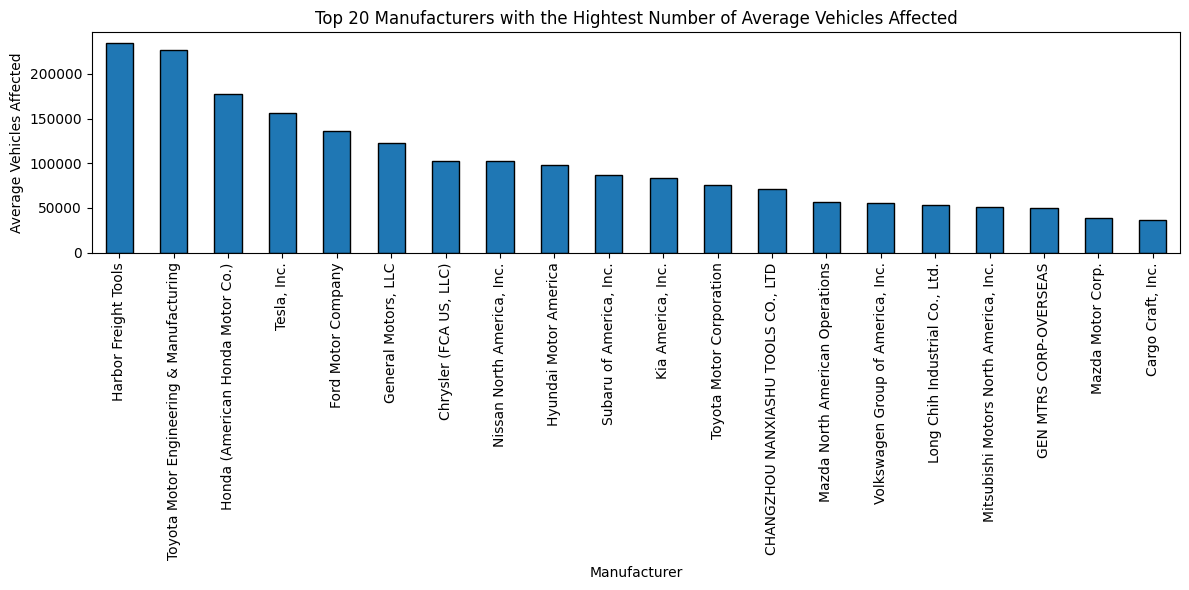

In [ ]:
#Vehicles Affected per Manufacturer
vehicles_per_manufacturer = recall_df.groupby('Manufacturer')['Potentially Affected'].agg(['mean','median','min','max']).sort_values('mean', ascending=False)
print(vehicles_per_manufacturer.head(20))

#plot of average vehicles affected for the top 20 manufacturers
vehicles_per_manufacturer['mean'].head(top_n).plot(kind='bar', edgecolor='black', figsize=(12,6))
plt.title('Top 20 Manufacturers with the Hightest Number of Average Vehicles Affected')
plt.xlabel('Manufacturer')
plt.ylabel('Average Vehicles Affected')
plt.tight_layout()
plt.show()


##Clustering

In [ ]:
# only uses potentially_affected (log transformed), year, manufacturer here too.
# find besk K with both Elbow method and Silhoutte method > best k = 3
# labeling the severitiy clustering: 0 > low / 1 > medium / 2 > high
# simple visualization but we can add more if we need

In [ ]:

def make_design(df: pd.DataFrame, topN=100):

    required = ["Manufacturer", "Year", "Potentially_Affected_LogTransform", "Potentially Affected"]
    missing = [c for c in required if c not in df.columns]
    if missing:
        raise ValueError(f"Missing required columns: {missing}")

    # Work on a local copy
    d = recall_df[required].copy()

    # Limit manufacturer categories
    top = d["Manufacturer"].value_counts().head(topN).index
    d["Manufacturer_reduced"] = np.where(d["Manufacturer"].isin(top), d["Manufacturer"], "Other")

    # One-hot encode manufacturers
    manu = pd.get_dummies(d["Manufacturer_reduced"], prefix="m", drop_first=False).astype("float32")


    # Standardize Year + log-transformed numeric column
    scaler = StandardScaler()
    num = d[["Potentially_Affected_LogTransform", "Year"]].astype("float32")
    num_scaled = pd.DataFrame(
        scaler.fit_transform(num),
        columns=["Potentially_Affected_LogTransform_z", "Year_z"],
        index=d.index,
        dtype="float32"
    )

    # Combine numeric + categorical
    X = pd.concat([num_scaled, manu], axis=1)

    # Keep a copy for labeling later
    df_raw = d[["Manufacturer", "Year", "Potentially Affected"]].copy()
    return X, df_raw


# Prepare features for clustering
X, df_raw = make_design(recall_df)

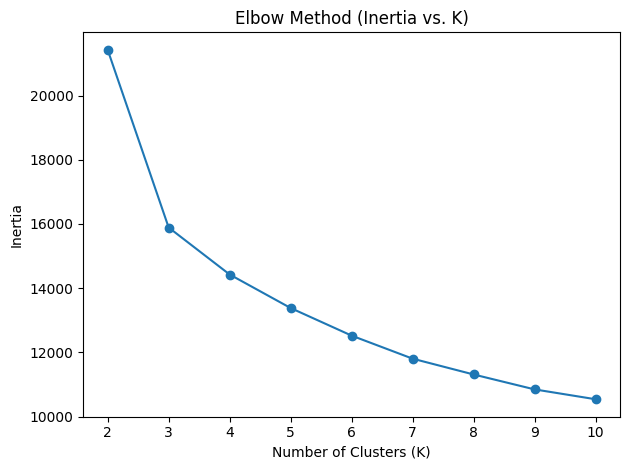

[Elbow] Candidate K = 3
[Silhouette] Candidate K = 3
[Suggested] Best K = 3 (verify using both plots if 3 != 3)


In [ ]:
# Using both Elbow method and Silhouette method to find best k

def find_best_k(X: pd.DataFrame, k_range=range(2, 11), elbow_sample=10000, sil_sample=8000, random_state=RANDOM_STATE):
    #Determine the optimal number of clusters (K) using both the Elbow Method and Silhouette Score.

    # Sampling (for faster computation)
    if len(X) > elbow_sample:
        idx_e = np.random.default_rng(random_state).choice(len(X), size=elbow_sample, replace=False)
        X_elbow = X.iloc[idx_e].values.astype("float32", copy=False)
    else:
        X_elbow = X.values.astype("float32", copy=False)

    if len(X) > sil_sample:
        idx_s = np.random.default_rng(random_state + 1).choice(len(X), size=sil_sample, replace=False)
        X_sil = X.iloc[idx_s].values.astype("float32", copy=False)
    else:
        X_sil = X.values.astype("float32", copy=False)

    # Compute inertia (Elbow) and silhouette scores
    inertia, sil = [], []
    for k in k_range:
        km = KMeans(n_clusters=k, n_init=10, max_iter=300, algorithm="elkan", random_state=random_state)
        labels_elbow = km.fit_predict(X_elbow)
        inertia.append(km.inertia_)

        # Silhouette score on the sampled subset
        labels_sil = km.predict(X_sil)
        sil.append(silhouette_score(X_sil, labels_sil))

    # Elbow plot
    list_k = list(k_range)
    plt.figure()
    plt.plot(list_k, inertia, marker='o')
    plt.title("Elbow Method (Inertia vs. K)")
    plt.xlabel("Number of Clusters (K)")
    plt.ylabel("Inertia")
    plt.tight_layout()
    plt.show()

    # Elbow criterion: choose K with the largest relative drop in inertia
    drops = (np.array(inertia[:-1]) - np.array(inertia[1:])) / np.array(inertia[:-1])
    k_elbow = list_k[np.argmax(drops) + 1]

    # Silhouette criterion: K with the highest silhouette score
    k_sil = list_k[int(np.argmax(sil))]

    # Summarize and recommend
    metrics = pd.DataFrame({
        "k": list_k,
        "inertia": inertia,
        "rel_drop_to_next": np.r_[drops, np.nan],
        "silhouette": sil
    })
    print(f"[Elbow] Candidate K = {k_elbow}")
    print(f"[Silhouette] Candidate K = {k_sil}")

    best_k = k_elbow if k_elbow == k_sil else k_elbow
    print(f"[Suggested] Best K = {best_k} (verify using both plots if {k_elbow} != {k_sil})")

    return best_k, metrics

# Find best K
best_k, k_metrics = find_best_k(X, k_range=range(2, 11))

In [ ]:
def fit_kmeans_and_label(X: pd.DataFrame, df_raw: pd.DataFrame, k: int, random_state = RANDOM_STATE):
    Xv = X.values.astype("float32", copy=False)

    km = KMeans(n_clusters=k, n_init=10, max_iter=300, algorithm="elkan", random_state=random_state)
    labels = km.fit_predict(Xv)

    out = df_raw.copy()
    out["cluster"] = labels

    # Rank clusters by median "Potentially Affected"
    med_order = (
        out.groupby("cluster")["Potentially Affected"]
          .median().sort_values().index.tolist()
    )
    order_map = {c: i+1 for i, c in enumerate(med_order)}
    out["severity_level"] = out["cluster"].map(order_map)
    name_map = {1: "Low", 2: "Medium", 3: "High", 4: "Severe", 5: "Critical"}
    out["severity_label"] = out["severity_level"].map(lambda r: name_map.get(r, f"S{r}"))

    return out, km

# Run K-Means and label each recall by severity
df_labeled, model = fit_kmeans_and_label(X, df_raw, k=best_k)

=== Recall Severity Summary ===
                count       mean   median  min       max
severity_label                                          
Low             11995     246.74    102.0    0      2294
Medium           5883   17995.99    820.0    1   6682084
High             7686  113214.26  13613.5  895  21000000




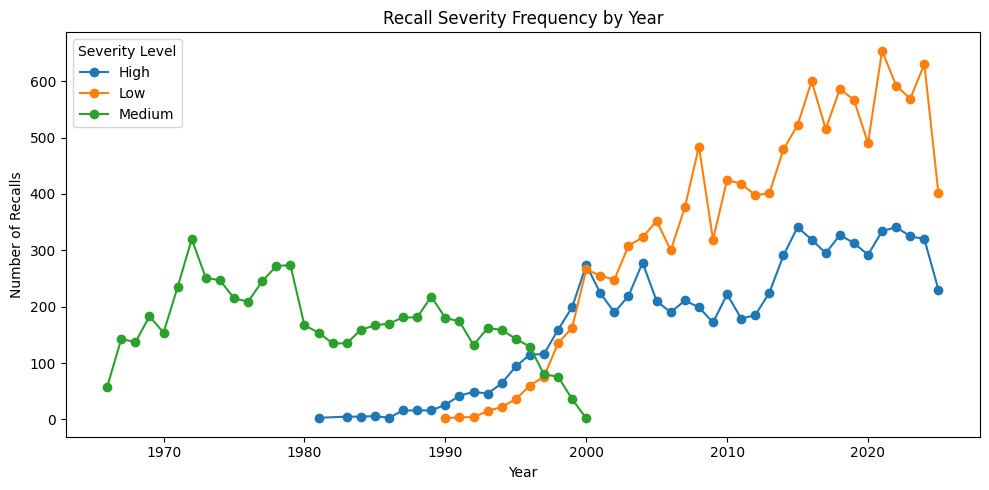

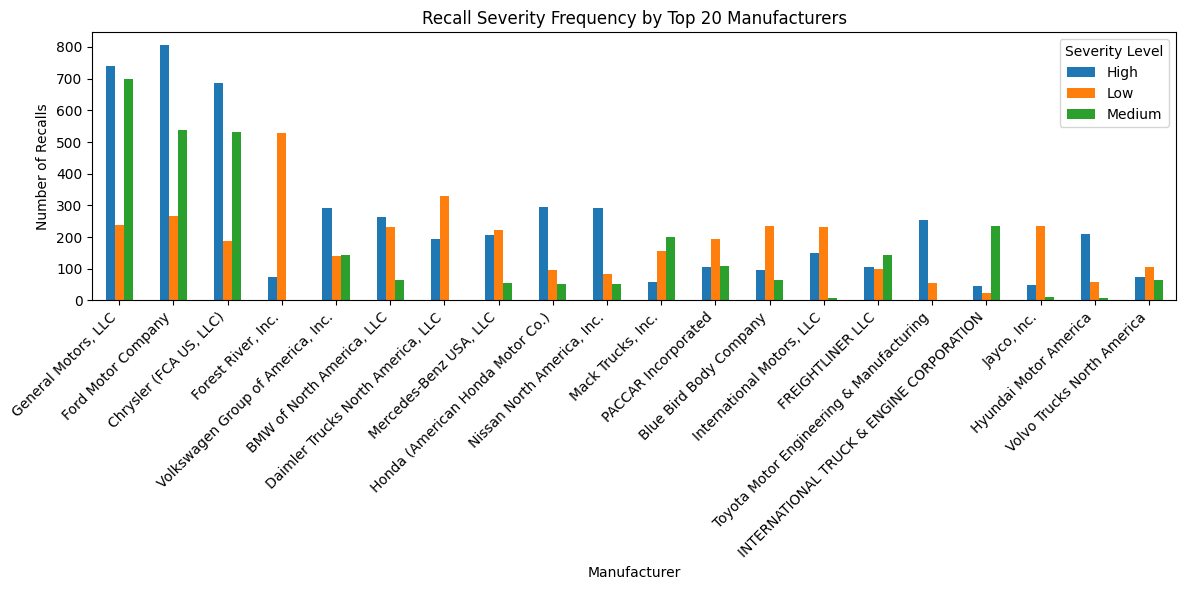

severity_label,High,Low,Medium
Manufacturer,,,
"General Motors, LLC",739,237,699
Ford Motor Company,806,268,537
"Chrysler (FCA US, LLC)",687,189,531
"Forest River, Inc.",74,530,0
"Volkswagen Group of America, Inc.",293,141,143
"BMW of North America, LLC",263,233,63
"Daimler Trucks North America, LLC",194,329,0
"Mercedes-Benz USA, LLC",208,222,56
Honda (American Honda Motor Co.),296,97,51


In [ ]:
def summary_and_plots(df_labeled: pd.DataFrame, top_makers: int = 20):
    print("=== Recall Severity Summary ===")
    print(
        df_labeled.groupby("severity_label")["Potentially Affected"]
        .agg(["count", "mean", "median", "min", "max"])
        .sort_values("median")
        .round(2)
    )
    print("\n")

    # Yearly severity trends (Line = good for time trend)
    plt.figure(figsize=(10, 5))
    for lab, part in df_labeled.groupby("severity_label"):
        cnt = part["Year"].value_counts().sort_index()
        plt.plot(cnt.index, cnt.values, marker="o", label=lab)
    plt.title("Recall Severity Frequency by Year")
    plt.xlabel("Year")
    plt.ylabel("Number of Recalls")
    plt.legend(title="Severity Level")
    plt.tight_layout()
    plt.show()
    print("\n")

    # Top manufacturers (Bar = clearer for comparisons)
    topN = df_labeled["Manufacturer"].value_counts().head(top_makers).index
    sub = df_labeled[df_labeled["Manufacturer"].isin(topN)]

    # manufacturer × severity_label pivot
    pivot = (
        sub.groupby(["Manufacturer", "severity_label"])
        .size()
        .unstack(fill_value=0)
        .reindex(topN)
    )

    # get table by manufacturer
    pivot.plot(kind="bar", stacked=False, figsize=(12, 6))
    plt.title(f"Recall Severity Frequency by Top {top_makers} Manufacturers")
    plt.xlabel("Manufacturer")
    plt.ylabel("Number of Recalls")
    plt.xticks(rotation=45, ha="right")
    plt.legend(title="Severity Level")
    plt.tight_layout()
    plt.show()

    # pivot table of manufacturers × severity
    topN = df_labeled["Manufacturer"].value_counts().head(top_makers).index
    sub = df_labeled[df_labeled["Manufacturer"].isin(topN)]
    pivot = (
        sub.groupby(["Manufacturer", "severity_label"])
        .size()
        .unstack(fill_value=0)
        .reindex(topN)
    )

    return pivot

# Visualize and summarize
summary_and_plots(df_labeled, top_makers=20)

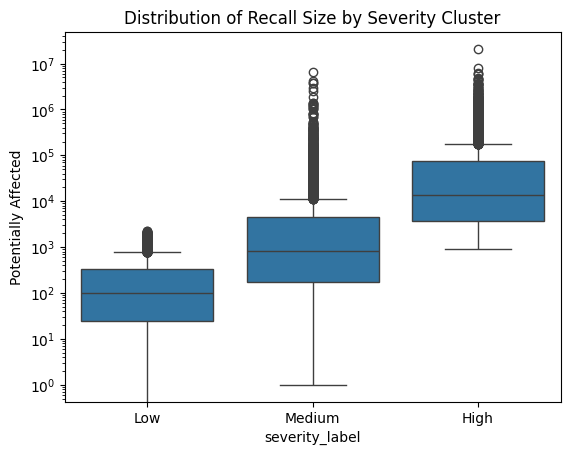

In [ ]:
order = ["Low", "Medium", "High"] # use this order so it is more clear, descriptive

sns.boxplot(
    x="severity_label",
    y="Potentially Affected",
    data=df_labeled,
    order=order
)
plt.title("Distribution of Recall Size by Severity Cluster")
plt.yscale("log")
plt.show()

# Confirms the clustering logic is effective in respect to severity levels correspond directly to recall magnitude
# The High cluster drives most large-scale events, representing systemic or critical failures
# The log normal shape suggests recall size distribution is heavily skewed, dominated by rare large recalls

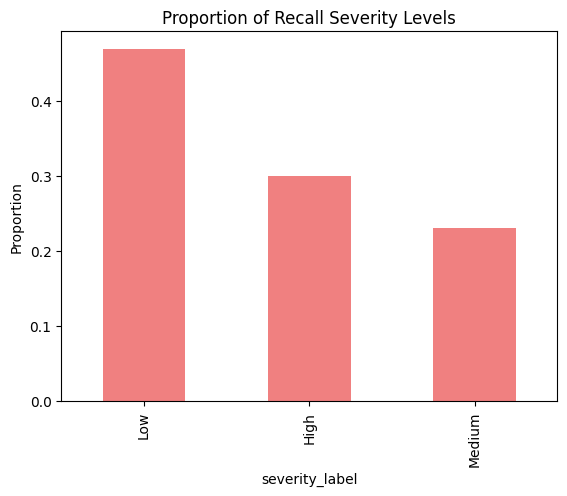

In [ ]:
df_labeled["severity_label"].value_counts(normalize=True).plot(kind="bar", color="lightcoral")
plt.title("Proportion of Recall Severity Levels")
plt.ylabel("Proportion")
plt.show()

Manufacturer Severity Rate Analysis

In [ ]:
# Top 20 manufacturers by number of recalls
top_makers = df_labeled["Manufacturer"].value_counts().head(20).index

# Filter dataset to include only these top manufacturers
df_top = df_labeled[df_labeled["Manufacturer"].isin(top_makers)].copy()

# Manufacturer × Severity label contingency table (counts)
maker_sev_counts = (
    df_top
    .groupby(["Manufacturer", "severity_label"])
    .size()
    .unstack(fill_value=0)
    .loc[top_makers]   # keep the order consistent with value_counts
)

# Convert counts to within-manufacturer severity rates (row-wise normalization)
maker_sev_rates = maker_sev_counts.div(maker_sev_counts.sum(axis=1), axis=0)

print("\n=== Severity Rate (within Manufacturer) ===")
print((maker_sev_rates * 100).round(1).head(20))


=== Severity Rate (within Manufacturer) ===
severity_label                            High   Low  Medium
Manufacturer                                                
General Motors, LLC                       44.1  14.1    41.7
Ford Motor Company                        50.0  16.6    33.3
Chrysler (FCA US, LLC)                    48.8  13.4    37.7
Forest River, Inc.                        12.3  87.7     0.0
Volkswagen Group of America, Inc.         50.8  24.4    24.8
BMW of North America, LLC                 47.0  41.7    11.3
Daimler Trucks North America, LLC         37.1  62.9     0.0
Mercedes-Benz USA, LLC                    42.8  45.7    11.5
Honda (American Honda Motor Co.)          66.7  21.8    11.5
Nissan North America, Inc.                68.6  19.4    11.9
Mack Trucks, Inc.                         13.9  37.7    48.3
PACCAR Incorporated                       25.9  47.6    26.6
Blue Bird Body Company                    23.9  59.4    16.6
International Motors, LLC               

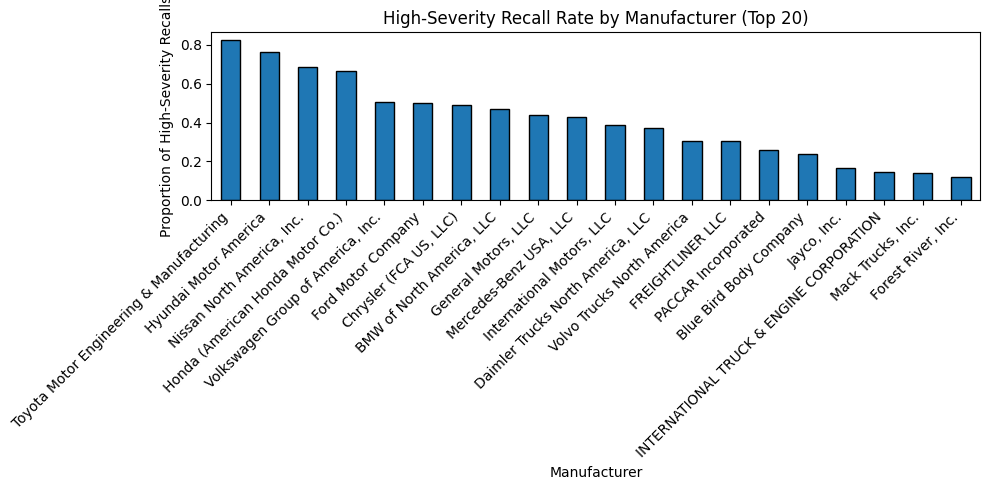

In [ ]:
# Extract High-severity rate (for top 20 manufacturers)
if "High" in maker_sev_rates.columns:
    high_rate = maker_sev_rates["High"].sort_values(ascending=False)
else:
    # If label variations exist such as 'high' or 'HIGH', print available labels
    print("Check severity_label values:", maker_sev_rates.columns)
    high_rate = maker_sev_rates.iloc[:, 0]  # fallback (manually adjust if needed)

plt.figure(figsize=(10, 5))
high_rate.plot(kind="bar", edgecolor="black")
plt.title("High-Severity Recall Rate by Manufacturer (Top 20)")
plt.ylabel("Proportion of High-Severity Recalls")
plt.xlabel("Manufacturer")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


In [ ]:
####### We can delete this comments #######

# Further analysis within the clustering: Distribution of components within each severity cluster
# Below two are same analysis with different visualization

In [ ]:
plt.figure(figsize=(10,6))
sns.heatmap(ct.loc[:, ct.sum() > 1], cmap="YlOrRd", annot=False)
plt.title("Component Distribution by Severity (%)")
plt.xlabel("Component")
plt.ylabel("Severity Label")
plt.tight_layout()
plt.show()


NameError: name 'ct' is not defined

<Figure size 1000x600 with 0 Axes>

In [ ]:
top_components = recall_df["Component"].value_counts().head(20).index
sub = recall_df[recall_df["Component"].isin(top_components)]

ct2 = pd.crosstab(df_labeled["severity_label"], sub["Component"], normalize='index') * 100

ct2.T.plot(kind="bar", figsize=(10,5))
plt.title("Top Components by Severity (%)")
plt.ylabel("Percentage within Severity")
plt.tight_layout()
plt.show()

print("=== Top 5 Components within Each Severity Cluster ===\n")
for severity in ct2.index:
    top5 = ct2.loc[severity].sort_values(ascending=False).head(5)
    print(f"{severity} severity:")
    for comp, pct in top5.items():
        print(f"  - {comp}: {pct:.2f}%")
    print()

## Clustering Evaluation

In [ ]:
#Cluster Evaluation

#Davies-Bouldin score
DB_score = davies_bouldin_score(
    X,
    df_labeled["cluster"].values
)
print(f"Davies–Bouldin score for (k={best_k}): {DB_score:.3f}")

#Calinski-Harabasz scores for
KVals = range(2, 6)
CH_scores = []

for k in KVals:
    km = KMeans(n_clusters=k, n_init=10, max_iter=300, algorithm="elkan", random_state=0)
    labels = km.fit_predict(X)
    ch = calinski_harabasz_score(X, labels)
    CH_scores.append(ch)
    print(f"K={k}, CH Score={ch:.2f}")

#Silhouette score
Sil_score = silhouette_score(
    X,
    df_labeled["cluster"].values
)

print(f"Silhouette score for (k={best_k}): {Sil_score:.3f}")

#DB score of 1.297 and silhouette score of 0.266 indicate moderate cluster separation with some overlap
#When combined with other evaluation metrics, such as the distribution of size by recall cluster, the DB and silhouette scores can be taken to indicate meaningful clustering in a messy real-world dataset
#CH score provides additional support for choosing K=3, since it's max among k-values

In [ ]:
#print evaluation results as table
best_k = 3

KVals = range(2,7)

DB_scores = []
CH_scores = []

for k in KVals:
  km = KMeans(n_clusters=k, n_init=10, max_iter=300, algorithm="elkan", random_state=0)
  labels = km.fit_predict(X)

  #compute metrics
  ch = calinski_harabasz_score(X, labels)
  db = davies_bouldin_score(X, labels)

  CH_scores.append(ch)
  DB_scores.append(db)

#create df
results_df = pd.DataFrame({
    "K": list(KVals),
    "Calinski-Harabasz": CH_scores,
    "Davies-Bouldin": DB_scores})

print(tabulate(results_df, headers='keys', tablefmt='fancy_grid', showindex=False))

#Silhouette score
Sil_score = silhouette_score(
    X,
    df_labeled["cluster"].values
)

print(f"Silhouette score for (k={best_k}): {Sil_score:.3f}")